# DICE
[DICE: Leveraging Sparsification for Out-of-Distribution Detection](https://arxiv.org/abs/2111.09805)

In [1]:
from typing import Dict, Tuple, Union

import torch
from torch import Tensor

import torchvision
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

from torchmetrics import Metric, CatMetric, MetricCollection
from torchmetrics.classification import BinaryROC, BinaryPrecisionRecallCurve
from torchmetrics.utilities.data import dim_zero_cat
from torchmetrics.functional.classification.precision_recall_curve import _binary_precision_recall_curve_compute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from models.densenet import DenseNet3
import util.svhn_loader as svhn

In [2]:
transform_cifar = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

datasets = {
  'CIFAR-10': torchvision.datasets.CIFAR10(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar),
  'CIFAR-100': torchvision.datasets.CIFAR100(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar), 
  'SVHN': svhn.SVHN('datasets/ood_datasets/svhn/', split='test', transform=transform_cifar, download=False),
  'dtd': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/dtd/images", transform=transform_cifar),
  'places365': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/places365/", transform=transform_cifar),
  'celebA': torchvision.datasets.CelebA(root='datasets/ood_datasets/', split='test', download=True, transform=transform_cifar),
  'iSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/iSUN", transform=transform_cifar),
  'LSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN", transform=transform_cifar),
  'LSUN_resize': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN_resize", transform=transform_cifar),
}

dataloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=512, shuffle=False) for k,v in datasets.items()
}

ood_dls = ['SVHN', 'LSUN', 'LSUN_resize', 'iSUN', 'dtd', 'places365']

device = 'cuda:0'
result_dfs = {}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BinaryPrecisionRecallCurveOut(BinaryPrecisionRecallCurve):
  def compute(self) -> Tuple[Tensor, Tensor, Tensor]:
    if self.thresholds is None:
      state = [1-dim_zero_cat(self.preds), 1-dim_zero_cat(self.target)]
    else:
      state = self.confmat.flip((1,2))
    return _binary_precision_recall_curve_compute(state, self.thresholds)

In [4]:
curves = MetricCollection({
  'roc': BinaryROC(compute_on_cpu=True),
  'prc_in': BinaryPrecisionRecallCurve(compute_on_cpu=True),
  'prc_out': BinaryPrecisionRecallCurveOut(compute_on_cpu=True)
})

In [5]:
def compute_metrics(curves:MetricCollection) -> Dict[str, float]:
  res = curves.compute()

  fpr, tpr, _ = res['roc']
  p_in, r_in, _ = res['prc_in']
  p_out, r_out, _ = res['prc_out']

  return {
    'FPR@95': fpr[tpr <= 0.95].max().item(),
    'DTErr': ((1-tpr+fpr)/2).min().item(),
    'AUROC': torch.trapz(tpr, fpr).item(),
    'AUPR_In': -torch.trapz(p_in, r_in).item(),
    'AUPR_Out': -torch.trapz(p_out, r_out).item(),
  }

def run(
  extractor:torch.fx.GraphModule,
  dataloader:torch.utils.data.DataLoader,
  is_ood:bool,
  curves:MetricCollection,
  device:str='cuda:0'
) -> Dict[str, Union[Tuple[Tensor, Tensor], MetricCollection]]:
  features = CatMetric(compute_on_cpu=True)
  for x, _ in tqdm(dataloader):
    with torch.no_grad():
      res = extractor(x.to(device))
      energy = torch.logsumexp(res['logit'], -1)/1000.0  # make sure that the value in [0,1] interval.
      target = torch.tensor([not is_ood]*energy.shape[0], dtype=torch.int)  # 1 for ID, 0 for OOD.
      features.update(res['feature'])
      curves.update(energy, target)
  return {
    'features': (features.compute().mean(dim=0), features.compute().std(dim=0)),
    'curves': curves
  }

## CIFAR-100

* No Sparsity

In [6]:
densenet = DenseNet3(100, 100, 12, reduction=0.5, bottleneck=True, dropRate=0.0, normalizer=None, p=None, info=None)
checkpoint = torch.load("./checkpoints/CIFAR-100/densenet/checkpoint_100.pth.tar", "cpu")
densenet.load_state_dict(checkpoint['state_dict'])
densenet.eval()

get_graph_node_names(densenet)[1]

['x',
 'conv1',
 'block1.layer.0.bn1',
 'block1.layer.0.relu',
 'block1.layer.0.conv1',
 'block1.layer.0.bn2',
 'block1.layer.0.relu_1',
 'block1.layer.0.conv2',
 'block1.layer.0.cat',
 'block1.layer.1.bn1',
 'block1.layer.1.relu',
 'block1.layer.1.conv1',
 'block1.layer.1.bn2',
 'block1.layer.1.relu_1',
 'block1.layer.1.conv2',
 'block1.layer.1.cat',
 'block1.layer.2.bn1',
 'block1.layer.2.relu',
 'block1.layer.2.conv1',
 'block1.layer.2.bn2',
 'block1.layer.2.relu_1',
 'block1.layer.2.conv2',
 'block1.layer.2.cat',
 'block1.layer.3.bn1',
 'block1.layer.3.relu',
 'block1.layer.3.conv1',
 'block1.layer.3.bn2',
 'block1.layer.3.relu_1',
 'block1.layer.3.conv2',
 'block1.layer.3.cat',
 'block1.layer.4.bn1',
 'block1.layer.4.relu',
 'block1.layer.4.conv1',
 'block1.layer.4.bn2',
 'block1.layer.4.relu_1',
 'block1.layer.4.conv2',
 'block1.layer.4.cat',
 'block1.layer.5.bn1',
 'block1.layer.5.relu',
 'block1.layer.5.conv1',
 'block1.layer.5.bn2',
 'block1.layer.5.relu_1',
 'block1.layer.5.c

In [7]:
return_nodes = {'view': 'feature', 'fc': 'logit'}
extractor = create_feature_extractor(densenet, return_nodes).to(device)

In [8]:
curves.reset()

res_id = run(extractor, dataloaders['CIFAR-100'], False, curves)

id_avg, id_std = res_id['features']
id_curves = res_id['curves']

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
ood_features = {}
ood_metrics = {}

for nm in ood_dls:
  curves = id_curves.clone()

  res_ood = run(extractor, dataloaders[nm], True, curves)

  ood_features[nm] = res_ood['features']
  ood_metrics[nm] = compute_metrics(res_ood['curves'])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(ood_metrics)
df['Avg.'] = df.mean(axis=1)
result_dfs['CIFAR-100_energy'] = df.T

df.T[['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.875400,0.818515,0.863067
LSUN,0.147800,0.974348,0.976312
LSUN_resize,0.707300,0.801376,0.814240
iSUN,0.746106,0.789539,0.817554
dtd,0.843617,0.710096,0.765005
places365,0.782843,0.781495,0.141730
Avg.,0.683844,0.812562,0.729651


* With Sparsity $p=90$

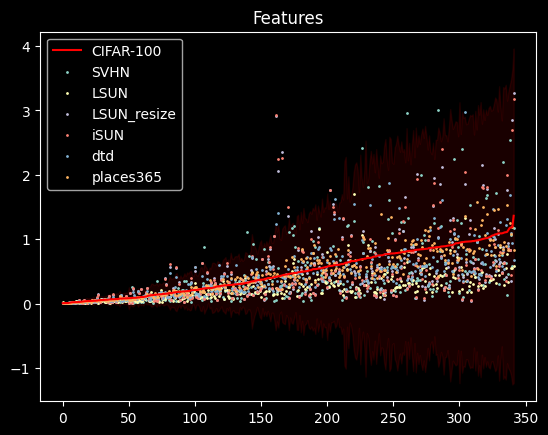

In [11]:
idx = id_avg.argsort()

plt.title('Features')
plt.plot(range(len(idx)), id_avg[idx], color='red', label='CIFAR-100')
plt.fill_between(
  range(len(idx)),
  id_avg[idx] - 2*id_std[idx],
  id_avg[idx] + 2*id_std[idx],
  color='red', alpha=.1
)

for k, (avg, std) in ood_features.items():
  plt.scatter(range(len(idx)), avg[idx], s=1, label=k)
  # plt.fill_between(range(len(idx)), avg[idx] - 2*std[idx], avg[idx] + 2*std[idx], alpha=.1)

plt.legend()
plt.show()

In [12]:
weight = extractor.fc.weight.data.cpu()
contrib = id_avg * weight
thresh = np.percentile(contrib, 90)
mask = contrib > thresh
extractor.fc.weight.data = (mask * weight).to(device)

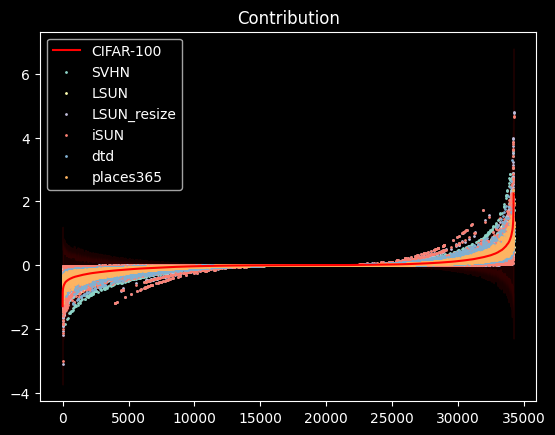

In [13]:
id_avg = (id_avg * weight).flatten()
id_std = (id_std * weight).flatten()
idx = id_avg.argsort()

plt.title('Contribution')
plt.plot(range(len(idx)), id_avg[idx], color='red', label='CIFAR-100')
plt.fill_between(
  range(len(idx)),
  id_avg[idx] - 2*id_std[idx],
  id_avg[idx] + 2*id_std[idx],
  color='red', alpha=.1
)

for k, (avg, std) in ood_features.items():
  avg, std = (avg * weight).flatten(), (std * weight).flatten()
  plt.scatter(range(len(idx)), avg[idx], s=1, label=k)
  # plt.fill_between(range(len(idx)), avg[idx] - 2*std[idx], avg[idx] + 2*std[idx], alpha=.1)

plt.legend()
plt.show()

In [14]:
curves.reset()

res_id = run(extractor, dataloaders['CIFAR-100'], False, curves)

id_avg, id_std = res_id['features']
id_curves = res_id['curves']

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
ood_features = {}
ood_metrics = {}

for nm in ood_dls:
  curves = id_curves.clone()

  res_ood = run(extractor, dataloaders[nm], True, curves)

  ood_features[nm] = res_ood['features']
  ood_metrics[nm] = compute_metrics(res_ood['curves'])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

In [16]:
df = pd.DataFrame(ood_metrics)
df['Avg.'] = df.mean(axis=1)
result_dfs['CIFAR-100_dice'] = df.T

df.T[['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.591500,0.886079,0.903695
LSUN,0.009200,0.997392,0.997412
LSUN_resize,0.516800,0.893147,0.902909
iSUN,0.494006,0.894948,0.909927
dtd,0.612234,0.771527,0.793554
places365,0.802904,0.774476,0.140147
Avg.,0.504441,0.869595,0.774607


## CIFAR-10

* No Sparsity

In [17]:
densenet = DenseNet3(100, 10, 12, reduction=0.5, bottleneck=True, dropRate=0.0, normalizer=None, p=None, info=None)
checkpoint = torch.load("./checkpoints/CIFAR-10/densenet/checkpoint_100.pth.tar", "cpu")
densenet.load_state_dict(checkpoint['state_dict'])
densenet.eval()

return_nodes = {'view': 'feature', 'fc': 'logit'}
extractor = create_feature_extractor(densenet, return_nodes).to(device)

In [18]:
curves.reset()

res_id = run(extractor, dataloaders['CIFAR-10'], False, curves)

id_avg, id_std = res_id['features']
id_curves = res_id['curves']

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
ood_features = {}
ood_metrics = {}

for nm in ood_dls:
  curves = id_curves.clone()

  res_ood = run(extractor, dataloaders[nm], True, curves)

  ood_features[nm] = res_ood['features']
  ood_metrics[nm] = compute_metrics(res_ood['curves'])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

In [20]:
df = pd.DataFrame(ood_metrics)
df['Avg.'] = df.mean(axis=1)
result_dfs['CIFAR-10_energy'] = df.T

df.T[['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.406300,0.939926,0.953340
LSUN,0.038100,0.991504,0.992562
LSUN_resize,0.092800,0.981238,0.984919
iSUN,0.100616,0.980683,0.986024
dtd,0.563121,0.864202,0.898692
places365,0.397665,0.918054,0.385097
Avg.,0.266434,0.945935,0.866772


* With Sparsity $p=90$

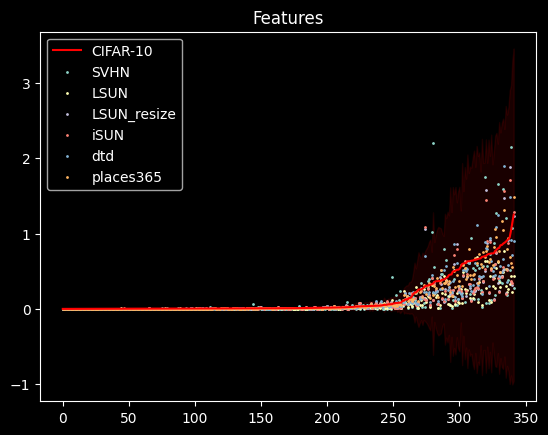

In [21]:
idx = id_avg.argsort()

plt.title('Features')
plt.plot(range(len(idx)), id_avg[idx], color='red', label='CIFAR-10')
plt.fill_between(
  range(len(idx)),
  id_avg[idx] - 2*id_std[idx],
  id_avg[idx] + 2*id_std[idx],
  color='red', alpha=.1
)

for k, (avg, std) in ood_features.items():
  plt.scatter(range(len(idx)), avg[idx], s=1, label=k)
  # plt.fill_between(range(len(idx)), avg[idx] - 2*std[idx], avg[idx] + 2*std[idx], alpha=.1)

plt.legend()
plt.show()

In [22]:
weight = extractor.fc.weight.data.cpu()
contrib = id_avg * weight
thresh = np.percentile(contrib, 90)
mask = contrib > thresh
extractor.fc.weight.data = (mask * weight).to(device)

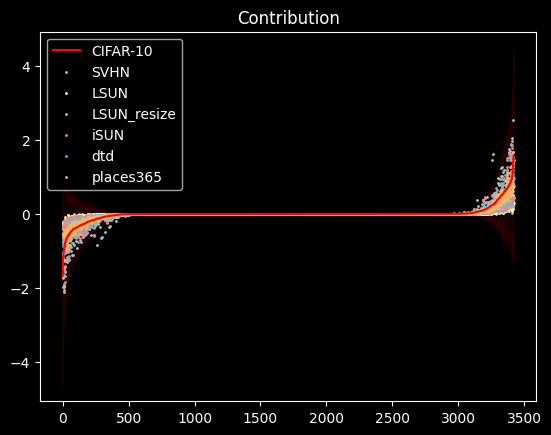

In [23]:
id_avg = (id_avg * weight).flatten()
id_std = (id_std * weight).flatten()
idx = id_avg.argsort()

plt.title('Contribution')
plt.plot(range(len(idx)), id_avg[idx], color='red', label='CIFAR-10')
plt.fill_between(
  range(len(idx)),
  id_avg[idx] - 2*id_std[idx],
  id_avg[idx] + 2*id_std[idx],
  color='red', alpha=.1
)

for k, (avg, std) in ood_features.items():
  avg, std = (avg * weight).flatten(), (std * weight).flatten()
  plt.scatter(range(len(idx)), avg[idx], s=1, label=k)
  # plt.fill_between(range(len(idx)), avg[idx] - 2*std[idx], avg[idx] + 2*std[idx], alpha=.1)

plt.legend()
plt.show()

In [24]:
curves.reset()

res_id = run(extractor, dataloaders['CIFAR-10'], False, curves)

id_avg, id_std = res_id['features']
id_curves = res_id['curves']

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
ood_features = {}
ood_metrics = {}

for nm in ood_dls:
  curves = id_curves.clone()

  res_ood = run(extractor, dataloaders[nm], True, curves)

  ood_features[nm] = res_ood['features']
  ood_metrics[nm] = compute_metrics(res_ood['curves'])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(ood_metrics)
df['Avg.'] = df.mean(axis=1)
result_dfs['CIFAR-10_dice'] = df.T

df.T[['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.297000,0.946658,0.952062
LSUN,0.003800,0.998986,0.998997
LSUN_resize,0.044700,0.990291,0.991147
iSUN,0.051541,0.989713,0.991639
dtd,0.459220,0.869672,0.888168
places365,0.451291,0.901546,0.333267
Avg.,0.217925,0.949478,0.859213


## Results

In [27]:
result_dfs['CIFAR-100_energy'][['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.875400,0.818515,0.863067
LSUN,0.147800,0.974348,0.976312
LSUN_resize,0.707300,0.801376,0.814240
iSUN,0.746106,0.789539,0.817554
dtd,0.843617,0.710096,0.765005
places365,0.782843,0.781495,0.141730
Avg.,0.683844,0.812562,0.729651


In [28]:
result_dfs['CIFAR-100_dice'][['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.591500,0.886079,0.903695
LSUN,0.009200,0.997392,0.997412
LSUN_resize,0.516800,0.893147,0.902909
iSUN,0.494006,0.894948,0.909927
dtd,0.612234,0.771527,0.793554
places365,0.802904,0.774476,0.140147
Avg.,0.504441,0.869595,0.774607


In [29]:
result_dfs['CIFAR-10_energy'][['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.406300,0.939926,0.953340
LSUN,0.038100,0.991504,0.992562
LSUN_resize,0.092800,0.981238,0.984919
iSUN,0.100616,0.980683,0.986024
dtd,0.563121,0.864202,0.898692
places365,0.397665,0.918054,0.385097
Avg.,0.266434,0.945935,0.866772


In [30]:
result_dfs['CIFAR-10_dice'][['FPR@95', 'AUROC', 'AUPR_In']]

,FPR@95,AUROC,AUPR_In
SVHN,0.297000,0.946658,0.952062
LSUN,0.003800,0.998986,0.998997
LSUN_resize,0.044700,0.990291,0.991147
iSUN,0.051541,0.989713,0.991639
dtd,0.459220,0.869672,0.888168
places365,0.451291,0.901546,0.333267
Avg.,0.217925,0.949478,0.859213
